In [21]:
import pandas as pd
import numpy as np
import os
import requests
import time
import json
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

# 1. read data

In [4]:
data1 = pd.read_csv("data/feedback_loop_1.csv")
data2 = pd.read_csv("data/feedback_loop_2.csv")

In [5]:
data1

,userid,movieid
0,961603,animal+crackers+1930
1,961603,gladiator+1992+1992
2,961603,sunset+boulevard+1950
3,961603,behind+the+mask+the+rise+of+leslie+vernon+2006
4,961603,last+life+in+the+universe+2003
...,...,...
64455,661168,last+life+in+the+universe+2003
64456,661168,rear+window+1954
64457,661168,au+revoir+les+enfants+1987
64458,661168,ashes+and+diamonds+1958


In [6]:
data2

,userid,movieid
0,986634,samsara+2011
1,986634,my+favorite+wife+1940
2,986634,yojimbo+1961
3,986634,modern+times+1936
4,986634,the+shawshank+redemption+1994
...,...,...
64075,449859,citizenfour+2014
64076,449859,housebound+2014
64077,449859,from+the+earth+to+the+moon+1998
64078,449859,the+holy+mountain+1973


# 2. get user and movie info

In [7]:
def get_user_info(x):
    uid = x["userid"]

    res = requests.get("http://128.2.204.215:8080/user/%s" %uid)
    if res.status_code != 200:
        print(uid, res.json())
        return x
    res = res.json()
    x["user_age"] = res["age"]
    x["user_occupation"] = res["occupation"]
    x["user_gender"] = res["gender"]

    return x


def get_movie_info(x):
    mid = x["movieid"]
        
    res = requests.get("http://128.2.204.215:8080/movie/%s" %mid)
    if res.status_code != 200:
        print(mid, res.json())
        return x
    res = res.json()
    if len(res['genres']) > 0:
        x["movie_genre"] = res['genres'][0]['name']

    return x

In [8]:
users1 = pd.DataFrame({'userid': data1.userid.unique()})
movies1 = pd.DataFrame({'movieid': data1.movieid.unique()})

users1 = users1.progress_apply(get_user_info, axis=1)
movies1 = movies1.progress_apply(get_movie_info, axis=1)

df1 = data1.merge(users1).merge(movies1)
df1["movie_genre"].fillna("None", inplace=True)

 83%|██████████████████████████████████▏      | 778/934 [00:34<00:05, 27.92it/s]

milk+2008 {'message': 'movie not found'}


100%|█████████████████████████████████████████| 934/934 [00:39<00:00, 23.37it/s]


In [15]:
users2 = pd.DataFrame({'userid': data2.userid.unique()})
movies2 = pd.DataFrame({'movieid': data2.movieid.unique()})

users2 = users2.progress_apply(get_user_info, axis=1)
movies2 = movies2.progress_apply(get_movie_info, axis=1)

df2 = data2.merge(users2).merge(movies2)
df2["movie_genre"].fillna("None", inplace=True)

100%|█████████████████████████████████████████| 934/934 [00:35<00:00, 26.25it/s]

emma+1996 {'message': 'movie not found'}


In [20]:
df1.sample(5)

,userid,movieid,user_age,user_occupation,user_gender,movie_genre
7655,23547,tender+mercies+1983,25,college/grad student,M,Drama
9755,652549,housebound+2014,22,homemaker,M,Horror
23405,725691,the+testament+of+dr.+mabuse+1933,29,self-employed,M,Crime
8093,921999,the+lady+vanishes+1938,32,homemaker,M,Mystery
60824,759372,the+wizard+of+oz+1939,25,writer,F,Adventure


# 3. Gender Bias Analysis on data1

In [22]:
df1.user_gender.value_counts()

M    53560
F    10900
Name: user_gender, dtype: int64

In [64]:
tmp = df1.groupby(["user_gender", "movie_genre"])[["movieid"]].count().reset_index()
tmp1 = tmp[tmp.user_gender=="M"].rename(columns={"movieid":"M_count"})
tmp2 = tmp[tmp.user_gender=="F"].rename(columns={"movieid":"F_count"})
tmp3 = pd.merge(tmp1[["movie_genre", "M_count"]], tmp2[["movie_genre", "F_count"]], how="outer", on="movie_genre")

In [51]:
tmp3

,movie_genre,M_count,F_count
0,Action,2312,425
1,Adventure,2602,528
2,Animation,1226,270
3,Comedy,6784,1359
4,Crime,2391,507
5,Documentary,5181,1058
6,Drama,26218,5370
7,Family,97,23
8,Fantasy,1130,219
9,History,181,35


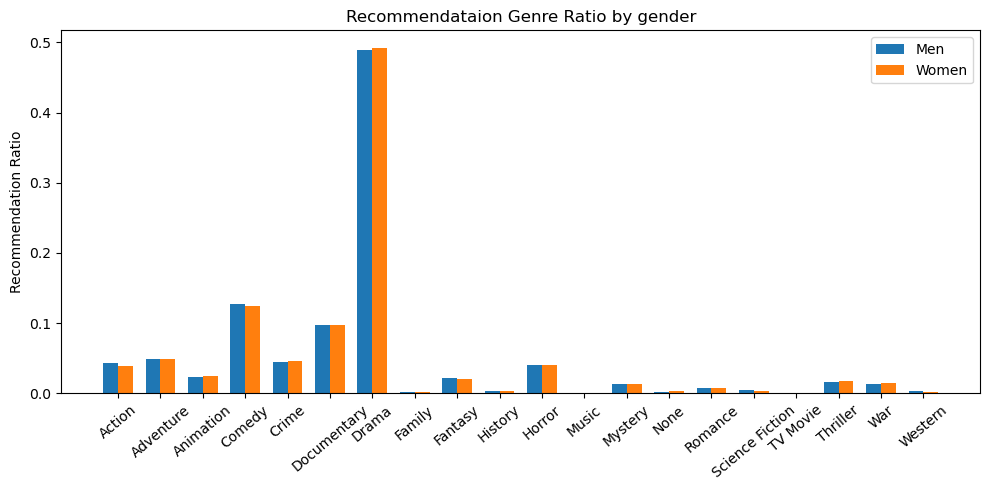

In [60]:
## genre and gender
M_sum = tmp3.M_count.sum()
F_sum = tmp3.F_count.sum()

x = np.arange(len(tmp3.movie_genre))  # the label locations
width = 0.35       # the width of the bars: can also be len(x) sequence

x1 = tmp[tmp.user_gender=="M"]["movie_genre"]
y1 = tmp[tmp.user_gender=="M"]["movieid"]

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - width/2, tmp3.M_count/M_sum, width, label='Men')
rects2 = ax.bar(x + width/2, tmp3.F_count/F_sum, width, label='Women')

# plt.xticks(rotation=40)
ax.set_xticks(x, tmp3.movie_genre, rotation=40)
ax.set_ylabel('Recommendation Ratio')
ax.set_title('Recommendataion Genre Ratio by gender')
ax.legend()

fig.tight_layout()

plt.show()

# 4. Gender Bias Analysis on data2

In [62]:
tmp_ = df2.groupby(["user_gender", "movie_genre"])[["movieid"]].count().reset_index()
tmp1_ = tmp_[tmp_.user_gender=="M"].rename(columns={"movieid":"M_count"})
tmp2_ = tmp_[tmp_.user_gender=="F"].rename(columns={"movieid":"F_count"})
tmp3_ = pd.merge(tmp1_[["movie_genre", "M_count"]], tmp2_[["movie_genre", "F_count"]], how="outer", on="movie_genre")

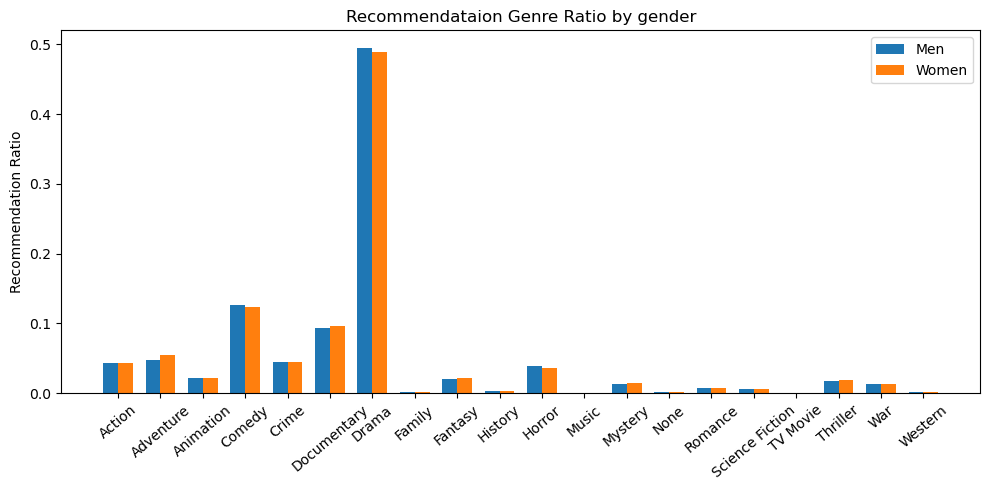

In [63]:
## genre and gender
M_sum = tmp3_.M_count.sum()
F_sum = tmp3_.F_count.sum()

x = np.arange(len(tmp3_.movie_genre))  # the label locations
width = 0.35       # the width of the bars: can also be len(x) sequence

x1 = tmp_[tmp_.user_gender=="M"]["movie_genre"]
y1 = tmp_[tmp_.user_gender=="M"]["movieid"]

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - width/2, tmp3_.M_count/M_sum, width, label='Men')
rects2 = ax.bar(x + width/2, tmp3_.F_count/F_sum, width, label='Women')

# plt.xticks(rotation=40)
ax.set_xticks(x, tmp3_.movie_genre, rotation=40)
ax.set_ylabel('Recommendation Ratio')
ax.set_title('Recommendataion Genre Ratio by gender')
ax.legend()

fig.tight_layout()

plt.show()